#### **Linux package installation**

In [ ]:
# %%sh
# pip install pandas numpy matplotlib pathlib seaborn
# sudo apt-get update
# sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{bm}')

In [9]:
DATA_DIR = Path().cwd().parent / "data"
assert DATA_DIR.exists(), f"{DATA_DIR} does not exist"

master_df = pd.read_json(DATA_DIR / "benchmark_df.json")

## Utilities

In [10]:
def df_filter(df: pd.DataFrame, *conditions) -> pd.DataFrame:
    mask = conditions[0]
    for condition in conditions[1:]:
        mask &= condition
    return df[mask]

## **Figure 01: Regret over iterations**

In [65]:
df = master_df.copy()
df = df.explode(["steps", "y_max_history"]).reset_index(drop=True)
df["regret"] = df.apply(lambda x: x.y_true_max - np.array(x.y_max_history), axis=1)
df["regret"] = pd.to_numeric(df.regret, errors="coerce")

df_stats = (
    df.groupby(["steps", "acq_func", "kernel_type", "n_dim", "len_scale"])["regret"]
        .agg(["count", "std", "sem", "mean"])
        .reset_index()
        .rename(columns={
            "mean": "y_mean", 
            "sem": "y_standard_error",
        })
        .assign(
            x=lambda x: x["steps"] - 4,
            y_lower=lambda x: x.y_mean - x.y_standard_error,
            y_upper=lambda x: x.y_mean + x.y_standard_error,
        )
)

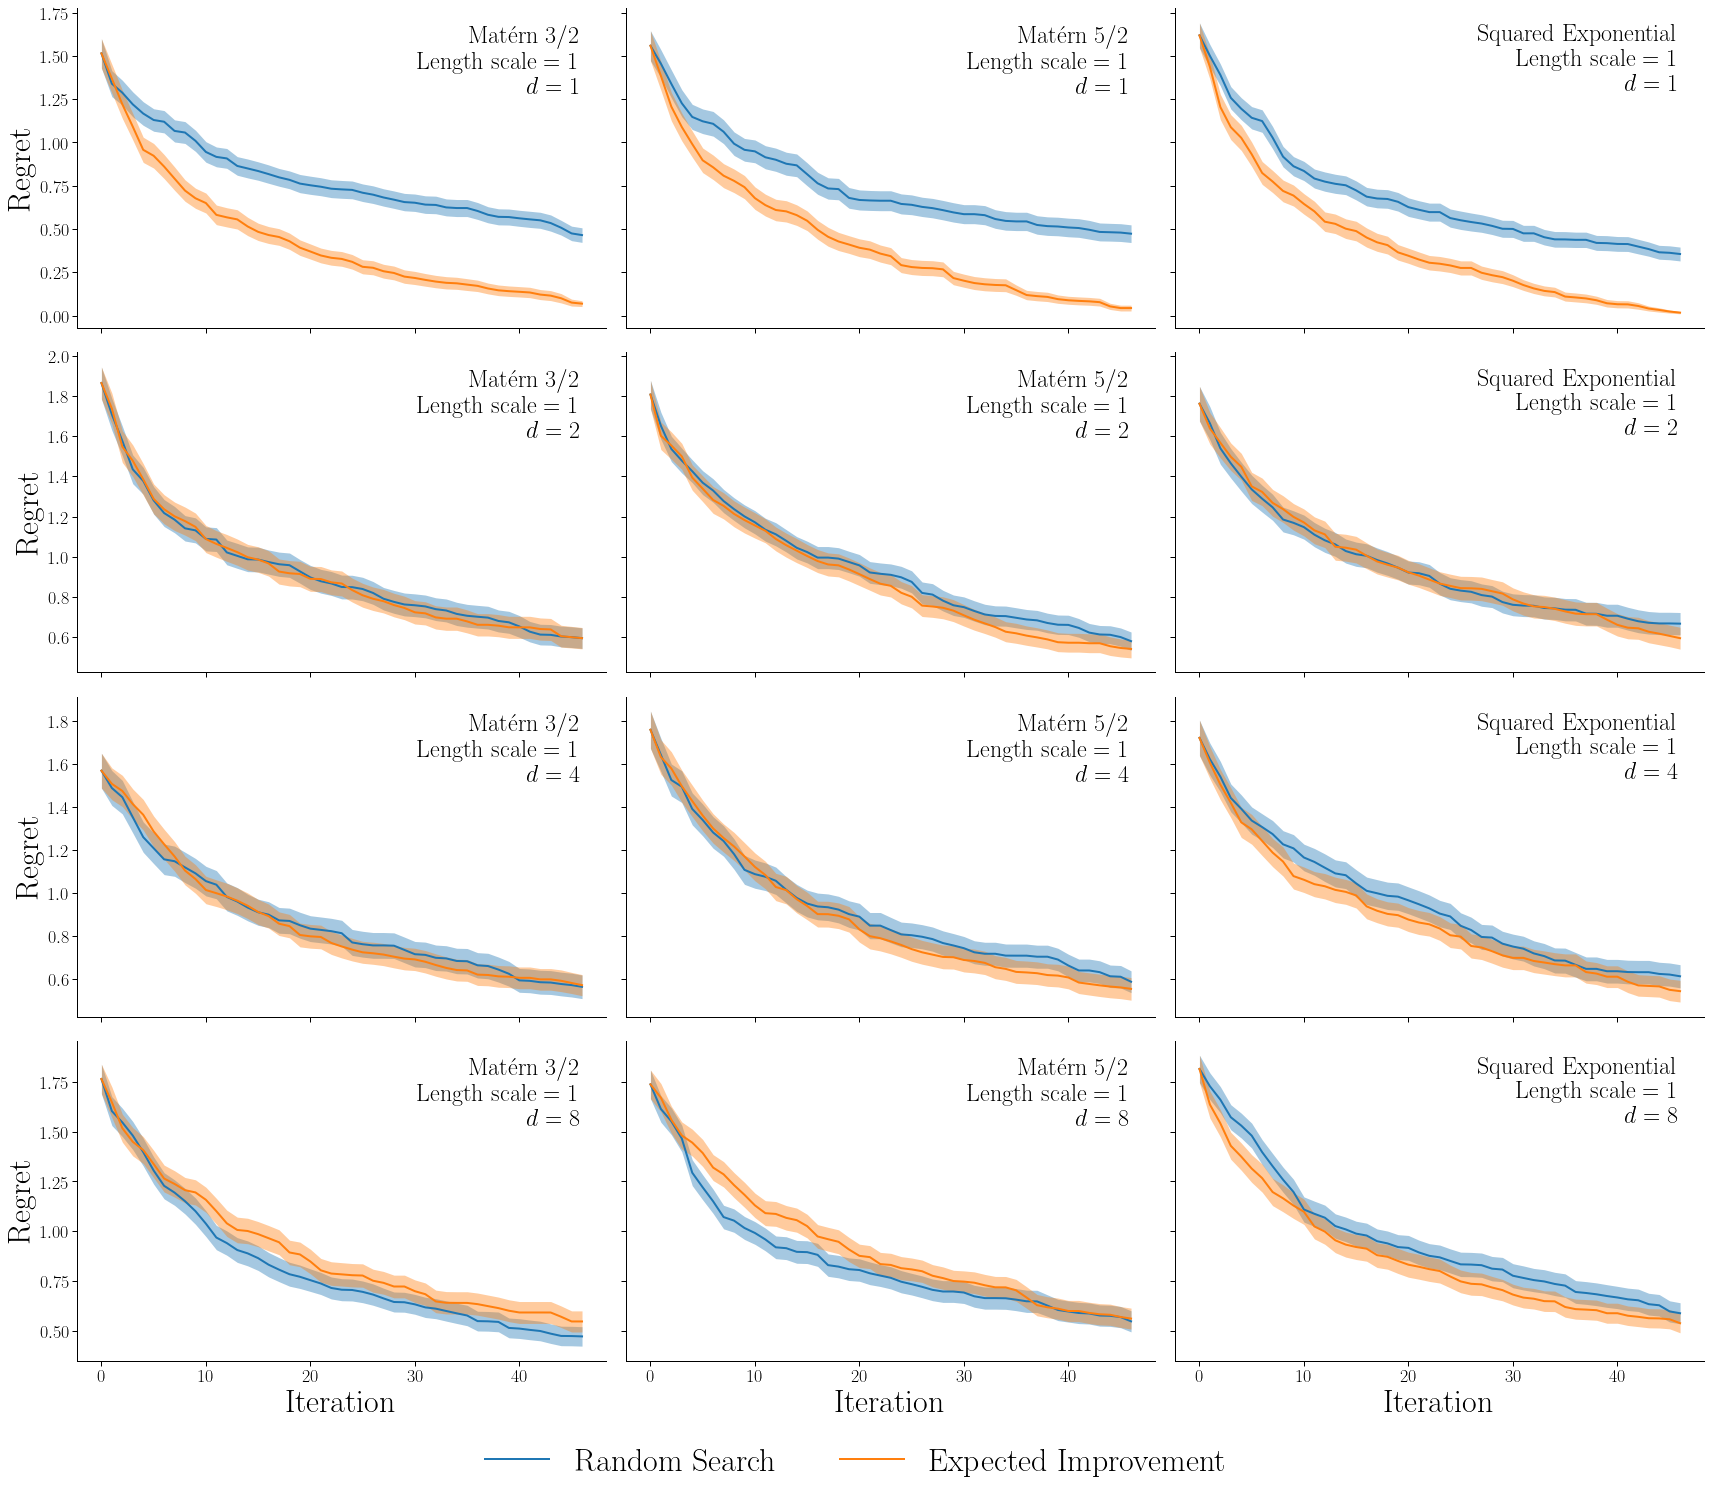

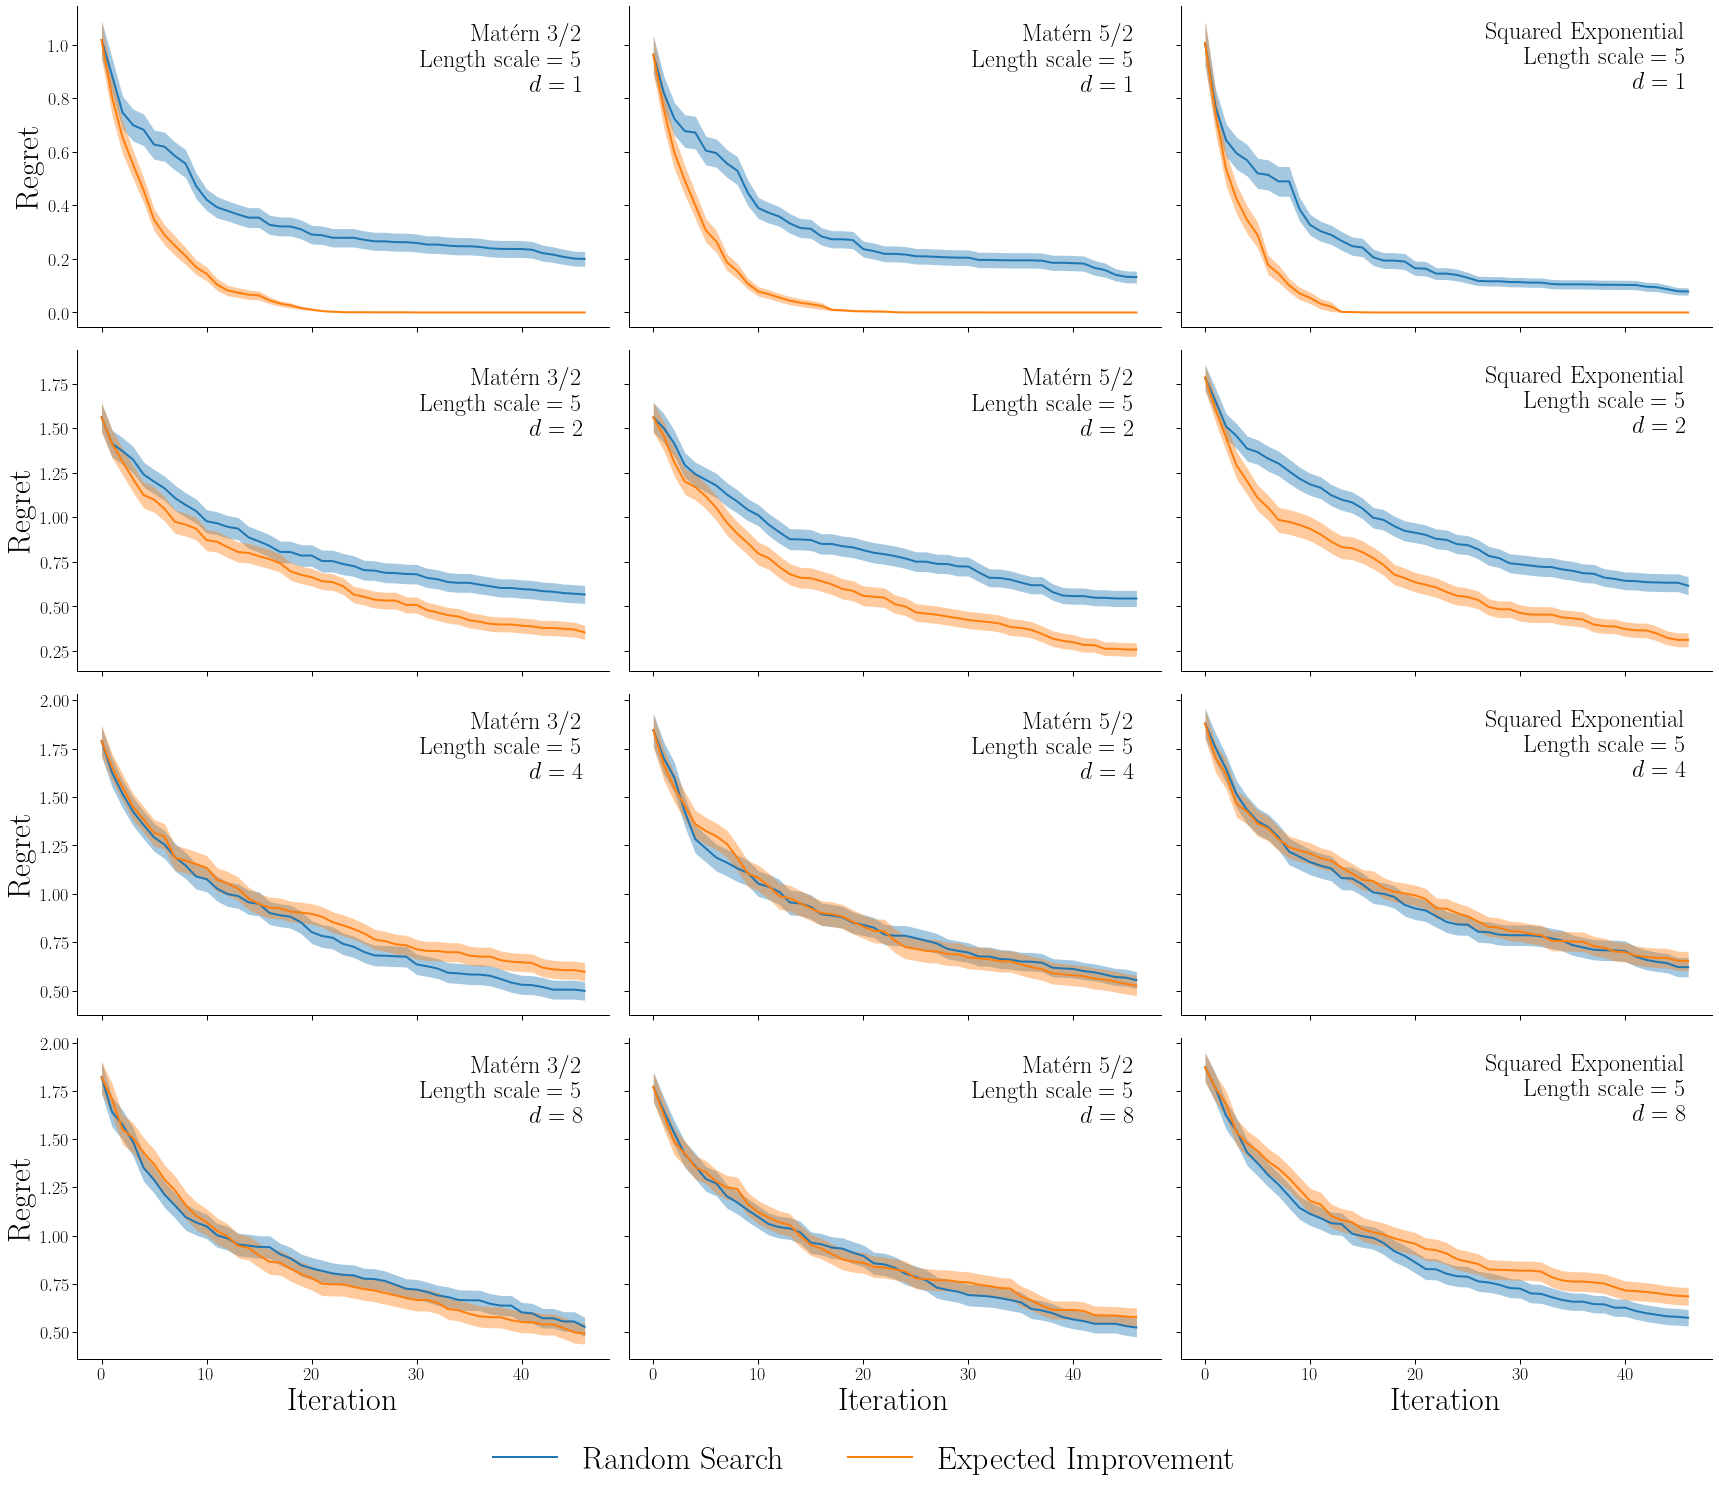

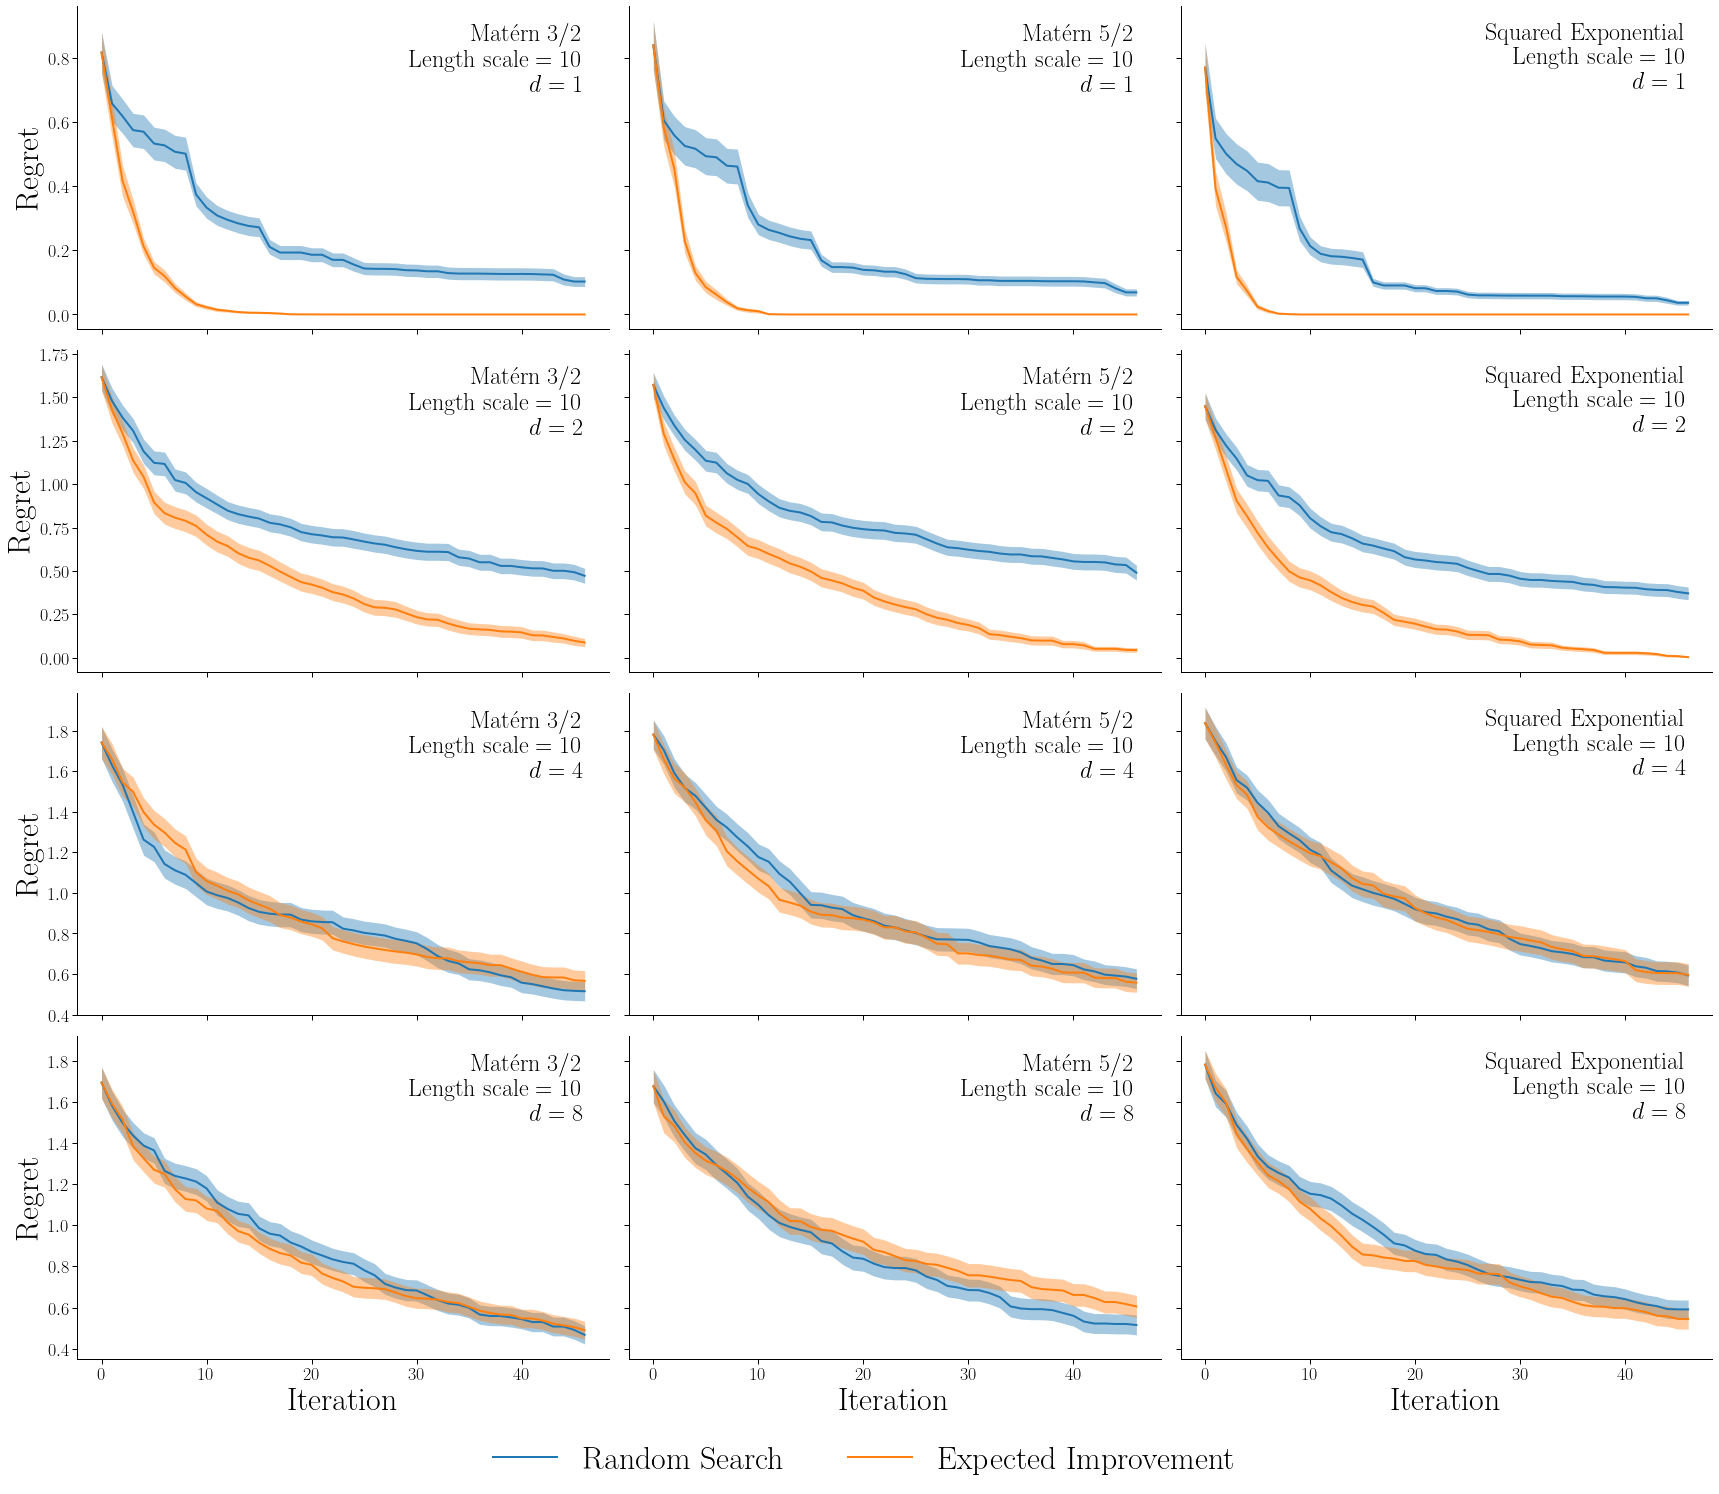

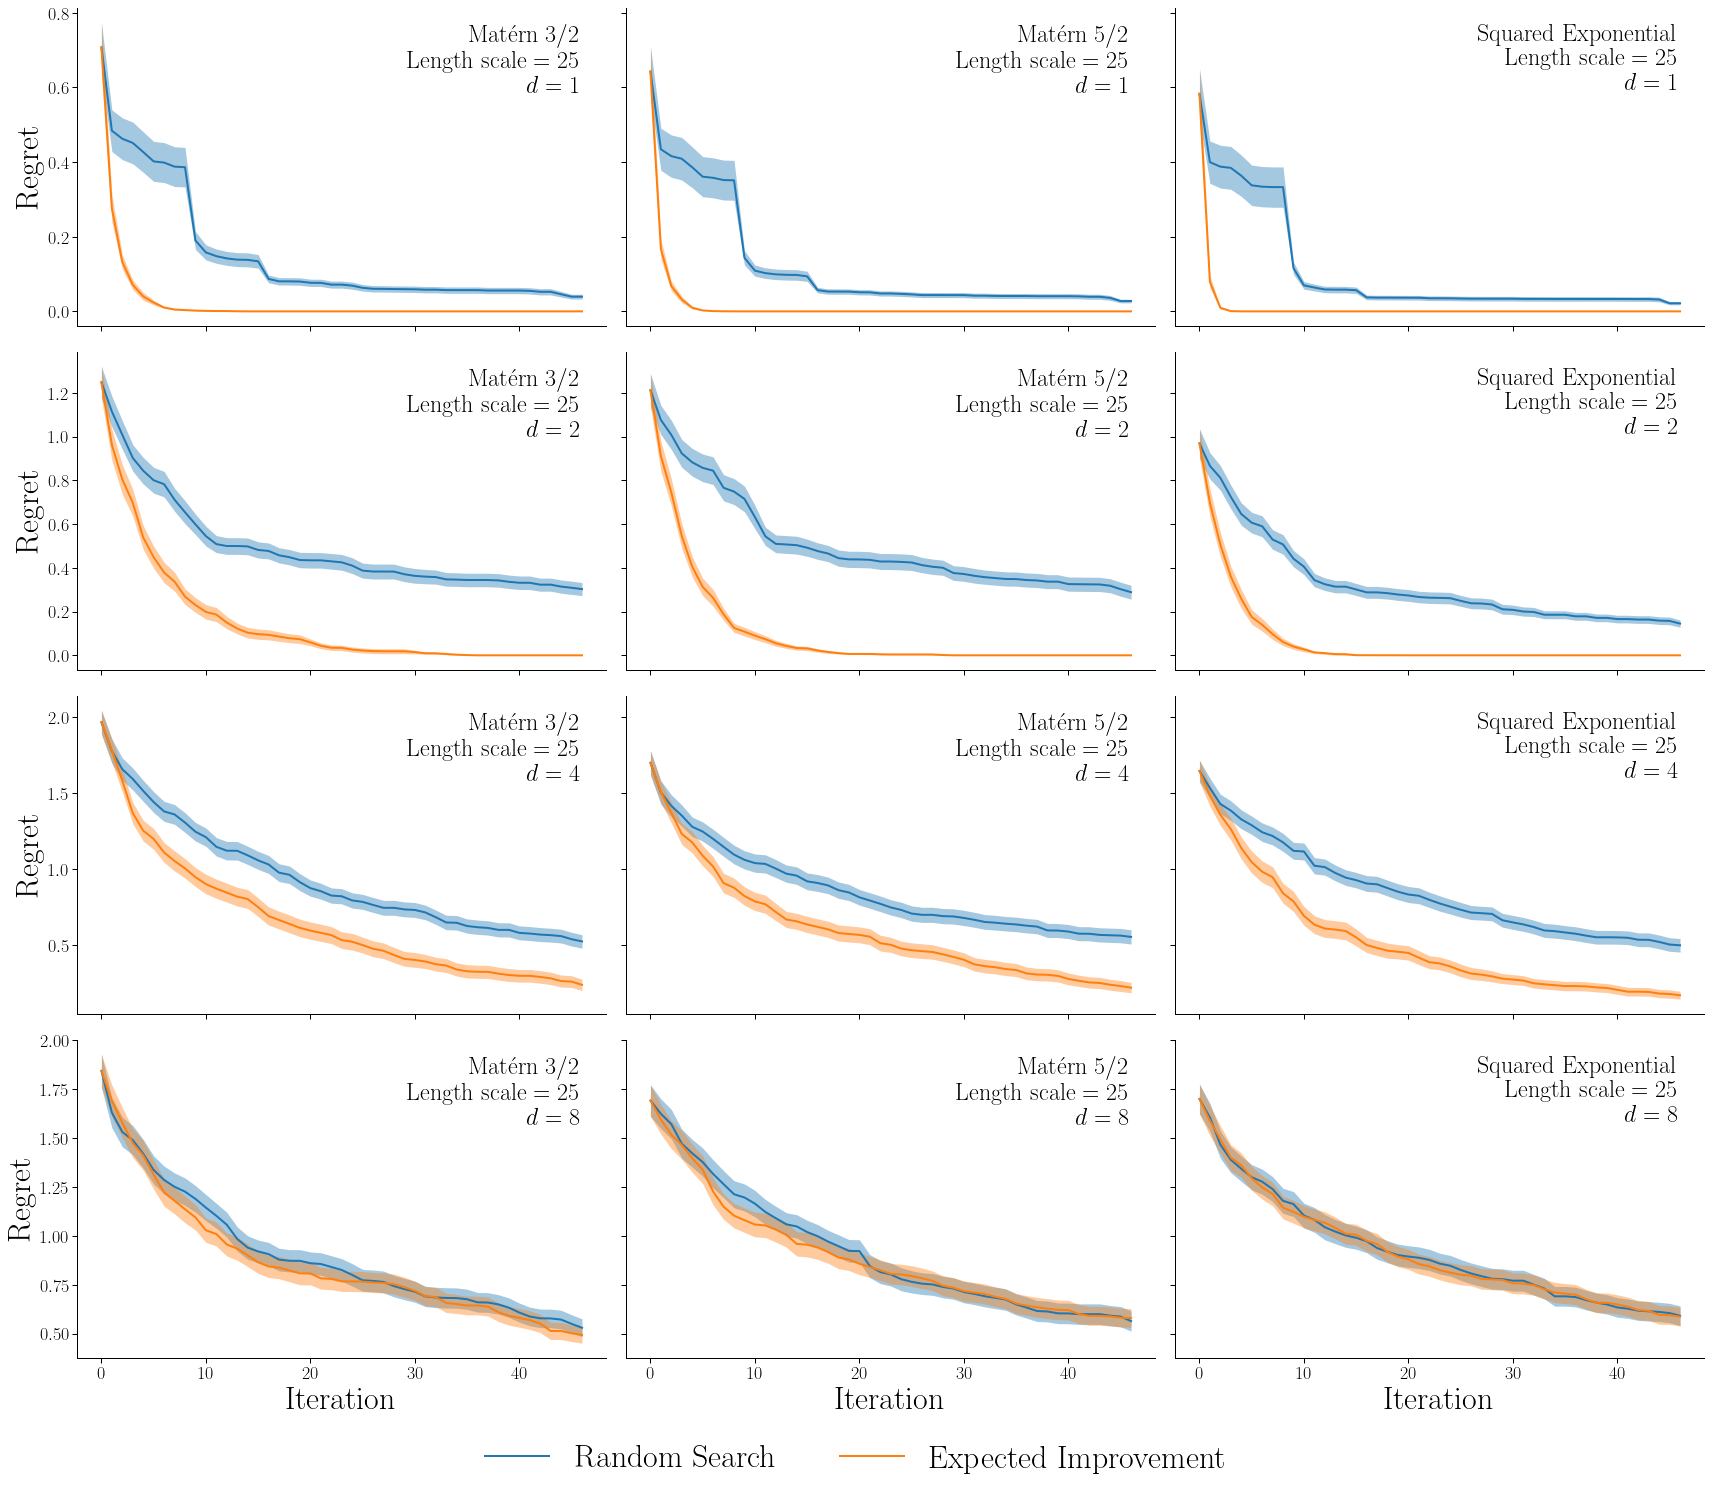

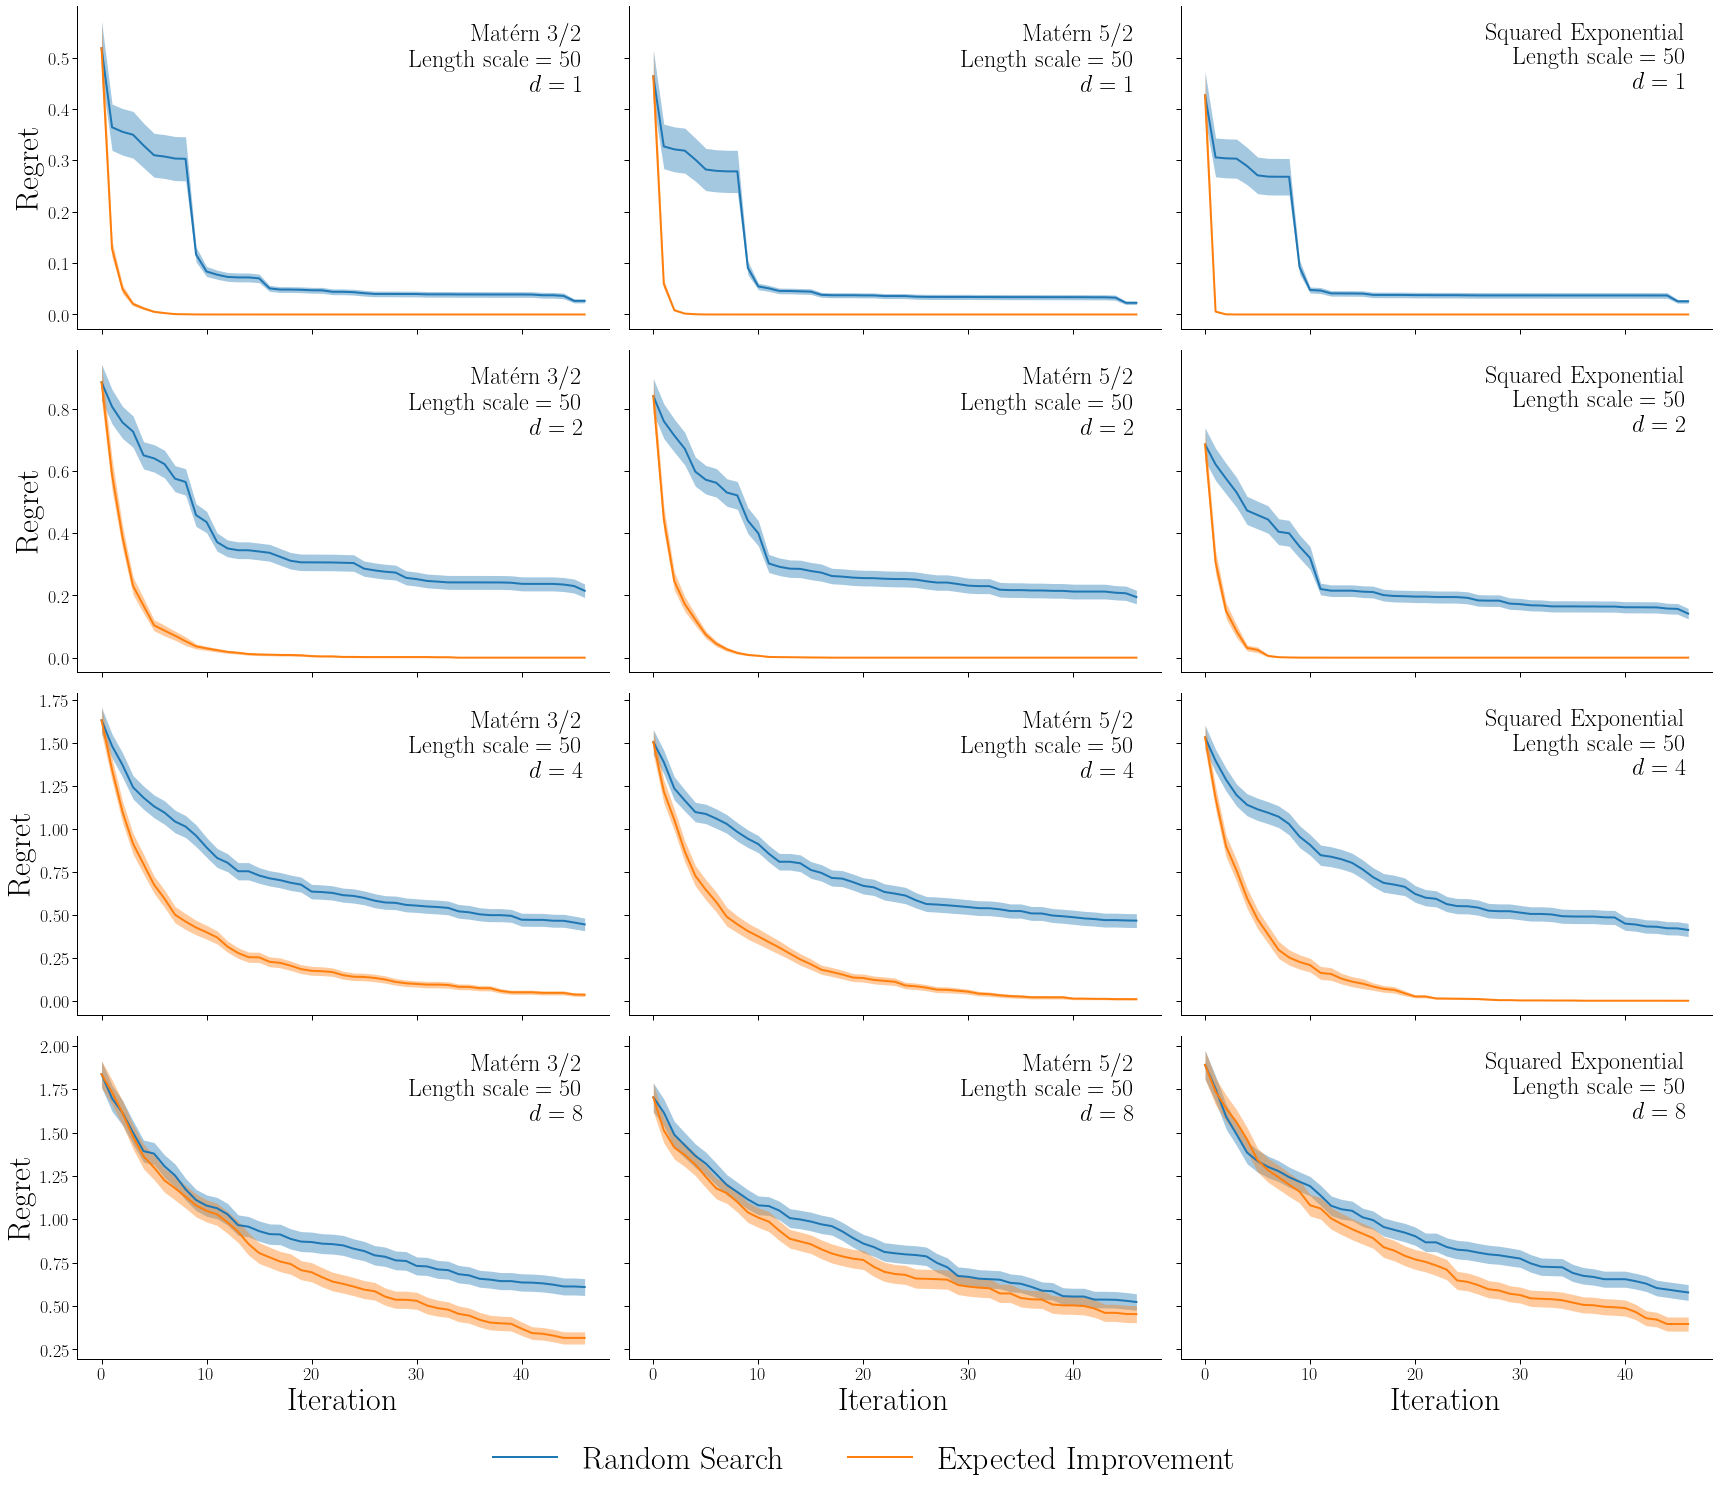

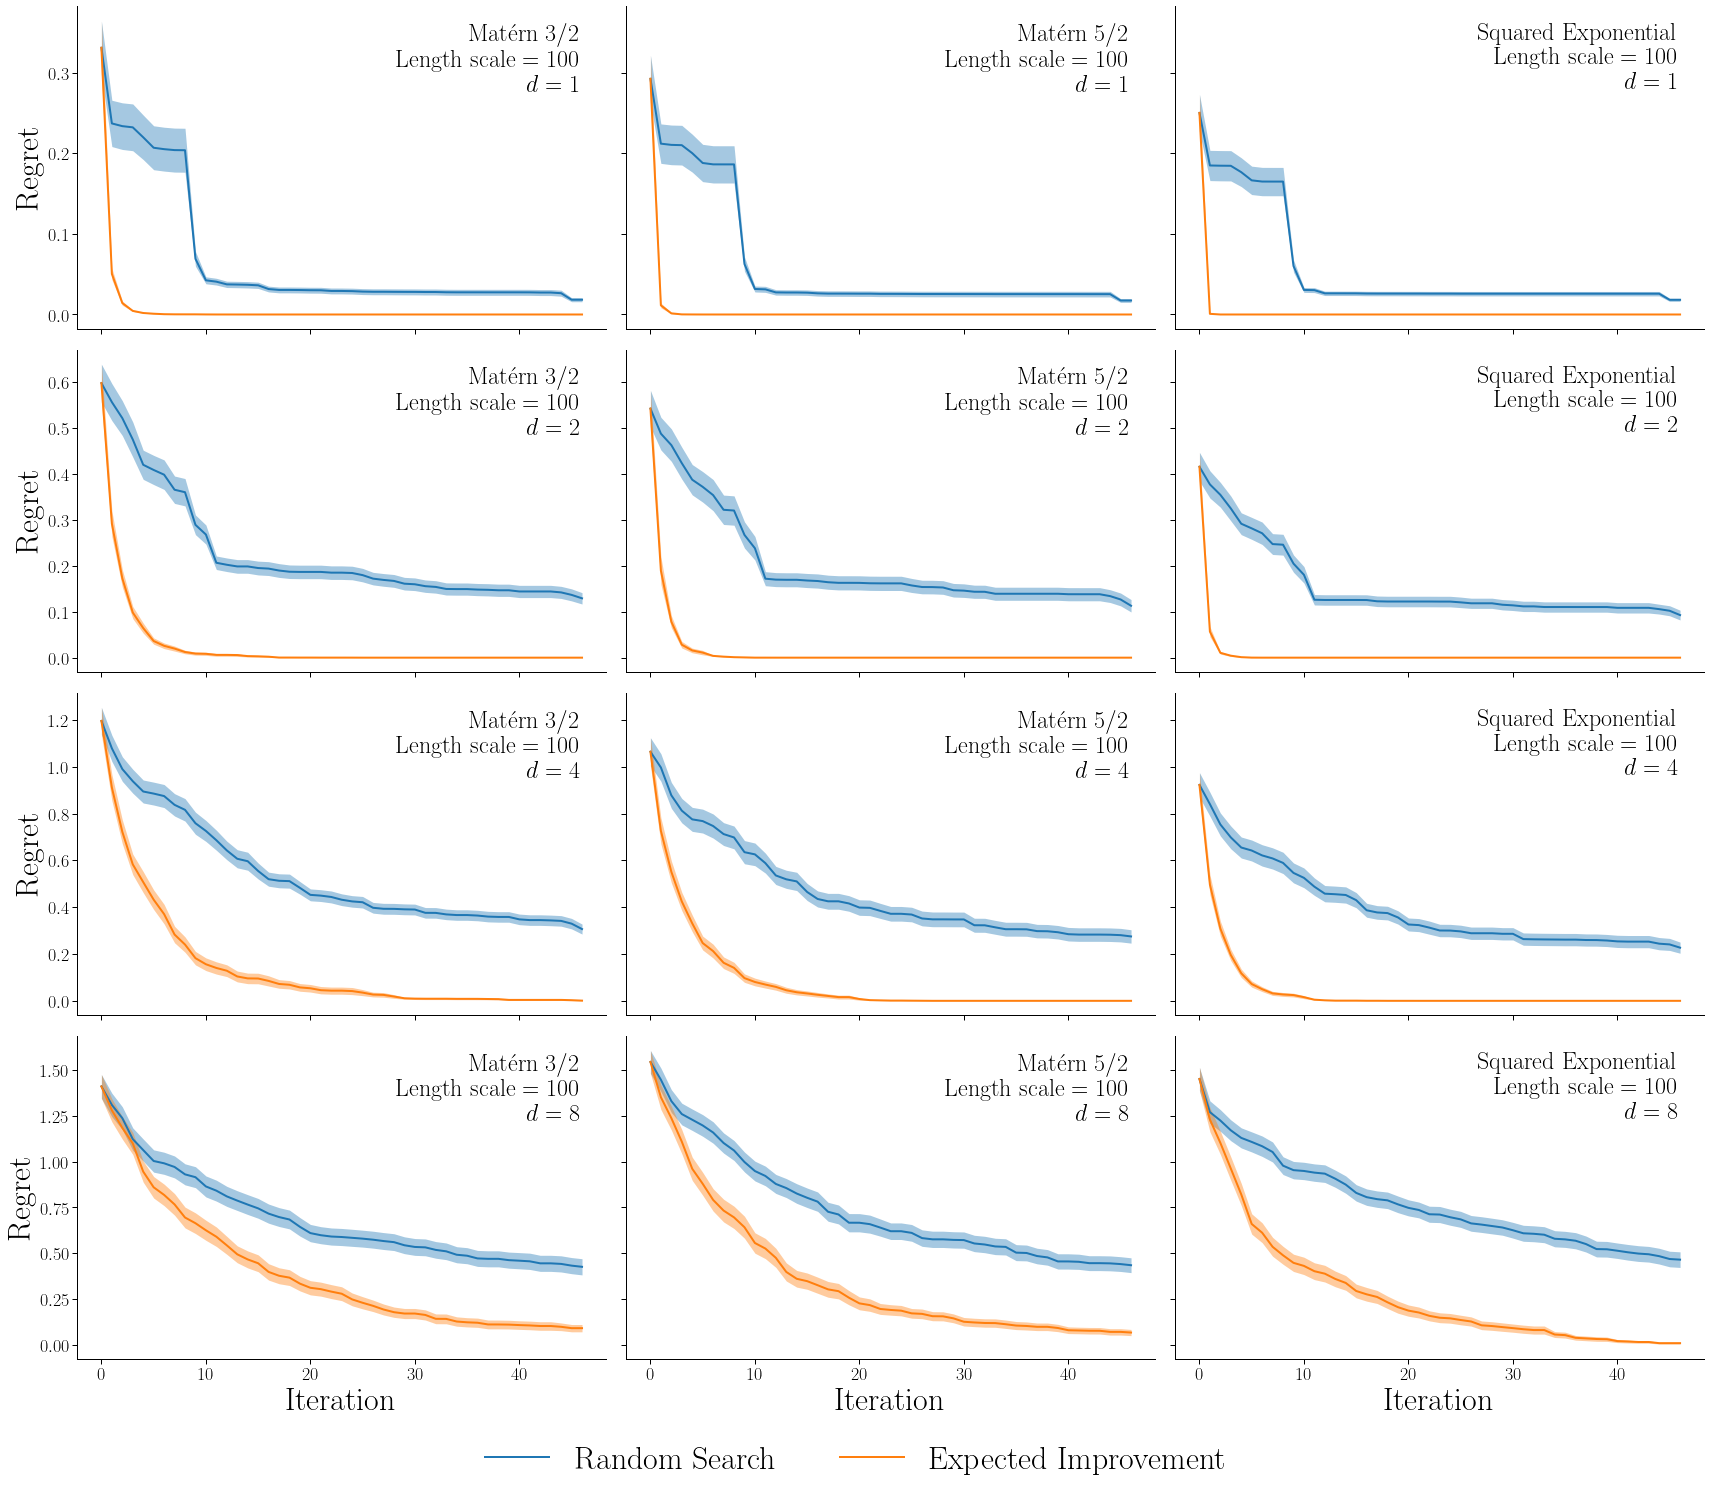

In [70]:
FIGSIZE = (8, 5)
TICK_FONT_SIZE = 18
AXIS_LABEL_FONT_SIZE = 32
SUBPLOT_TITLE_FONT_SIZE = 24
LEGEND_FONT_SIZE = 32

len_scales = [*sorted(set(df_stats.len_scale))]
kernel_types = [*sorted(set(df_stats.kernel_type))]
n_dims = [*sorted(set(df_stats.n_dim))]

len_scale_titles = {
    1: r"Length scale = $1$",
    5: r"Length scale = $5$",
    10: r"Length scale = $10$",
    25: r"Length scale = $25$",
    50: r"Length scale = $50$",
    100: r"Length scale = $100$",
}

kernel_type_titles = {
    "matern-3/2": r"Matérn $3/2$",
    "matern-5/2": r"Matérn $5/2$",
    "se": "Squared Exponential",
}

n_dim_titles = {
    1: r"$d=1$", 
    2: r"$d=2$", 
    4: r"$d=4$", 
    8: r"$d=8$", 
}

for len_scale in len_scales:

    fig, axs = plt.subplots(
        len(n_dims), 
        len(kernel_types), 
        figsize=(FIGSIZE[0] * len(kernel_types), FIGSIZE[1] * len(n_dims)),
        squeeze=True,
        sharex="col",
        sharey="row",
    )

    plot_df_stats = df_stats.copy()

    for n_dim_id, n_dim in enumerate(n_dims):
        for kernel_type_id, kernel_type in enumerate(kernel_types):

            ax = axs[n_dim_id][kernel_type_id]

            for line_id, acq_func in enumerate(set(df_stats.acq_func)):

                plot_stats = df_filter(
                    df_stats,
                    df_stats.kernel_type == kernel_type,
                    df_stats.n_dim == n_dim,
                    df_stats.acq_func == acq_func,
                    df_stats.len_scale == len_scale,
                )

                ax.plot(
                    plot_stats.x, 
                    plot_stats.y_mean, 
                    label=acq_func.replace("_", " ").title(),
                    linewidth=2,
                    color=f"C{line_id}",
                )

                ax.fill_between(
                    plot_stats.x,
                    plot_stats.y_lower,
                    plot_stats.y_upper,
                    alpha=0.4,
                    color=f"C{line_id}",
                    linewidth=0,
                )
                

            ax.text(
                0.95, 0.95,
                (
                    f"{kernel_type_titles[kernel_type]}\n"
                    f"{len_scale_titles[len_scale]}\n"
                    f"{n_dim_titles[n_dim]}\n"
                ),
                transform=ax.transAxes,
                ha="right", 
                va="top", 
                fontsize=SUBPLOT_TITLE_FONT_SIZE,
            )

            ax.tick_params(labelsize=TICK_FONT_SIZE)

            if n_dim_id == len(n_dims) - 1:
                ax.set_xlabel("Iteration", fontsize=AXIS_LABEL_FONT_SIZE)
            if kernel_type_id == 0:
                ax.set_ylabel("Regret", fontsize=AXIS_LABEL_FONT_SIZE)

            # ax.semilogy()
            sns.despine(ax=ax)


    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=len(labels),
        fontsize=LEGEND_FONT_SIZE,
        frameon=False,
    )

    plt.tight_layout()

    plt.savefig(f"figures/dev-figure-len-scale={len_scale}.pdf", bbox_inches="tight")
